In [1]:
# | default_exp models.neuralprophet

𝑦
^
𝑡
=
𝑇
(
𝑡
)
+
𝑆
(
𝑡
)
+
𝐸
(
𝑡
)
+
𝐹
(
𝑡
)
+
𝐴
(
𝑡
)
+
𝐿
(
𝑡
)


In [98]:
### Trend

In [1]:
import numpy as np
import torch
import torch.nn as nn

torch.manual_seed(42);

In [2]:
# Trend Model


class TrendModel(nn.Module):
    def __init__(self, n_changepoints=10, trend_reg=1.0):
        super(TrendModel, self).__init__()
        self.n_changepoints = n_changepoints
        self.trend_k = nn.Parameter(torch.zeros(1))  # Initial growth rate
        self.trend_m = nn.Parameter(torch.zeros(1))  # Initial offset
        self.delta = nn.Parameter(torch.zeros(n_changepoints))  # Changepoint adjustments
        self.trend_reg = trend_reg

    def forward(self, t, changepoints):
        t = t.view(-1, 1)
        changepoints = changepoints.view(1, -1)
        A = (t >= changepoints).float()
        growth = self.trend_k + torch.sum(self.delta * A, dim=1, keepdim=True)
        offset = self.trend_m - torch.sum(self.delta * changepoints * A, dim=1, keepdim=True)
        return growth * t + offset

In [3]:
# Synthetic Data


def generate_synthetic_data(n=1000):
    t = torch.linspace(0, n - 1, n)
    trend = 0.01 * t  # Base trend
    trend += (t >= 500).float() * 0.02 * (t - 500)  # Slope change at t=500
    noise = torch.normal(0, 0.1, size=(n,))
    y = trend + noise
    return t, y

<Axes: xlabel='None', ylabel='None'>

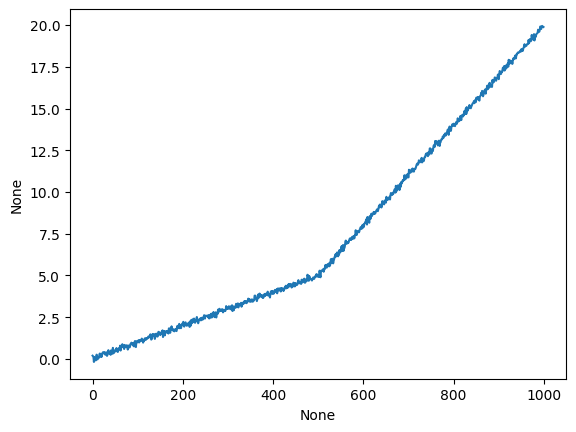

In [4]:
# Generate data
t, y = generate_synthetic_data(n=1000)
changepoints = torch.linspace(0, len(t) - 1, 10)
import seaborn as sns

sns.lineplot(x=t, y=y)

/home/pranav-pc/projects/ts/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/home/pranav-pc/projects/ts/.venv/lib/python3.12/site-packages/torch/autograd/graph.py:823: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0, Loss: 0.1975, LR: 0.001000
Epoch 20, Loss: 1.0047, LR: 0.000500
Epoch 40, Loss: 0.0758, LR: 0.000250
Epoch 60, Loss: 0.1261, LR: 0.000125
Epoch 80, Loss: 0.0433, LR: 0.000063
Epoch 100, Loss: 0.0409, LR: 0.000063
Epoch 120, Loss: 0.0402, LR: 0.000063
Epoch 140, Loss: 0.0395, LR: 0.000031
Epoch 160, Loss: 0.0368, LR: 0.000016
Epoch 180, Loss: 0.0363, LR: 0.000016


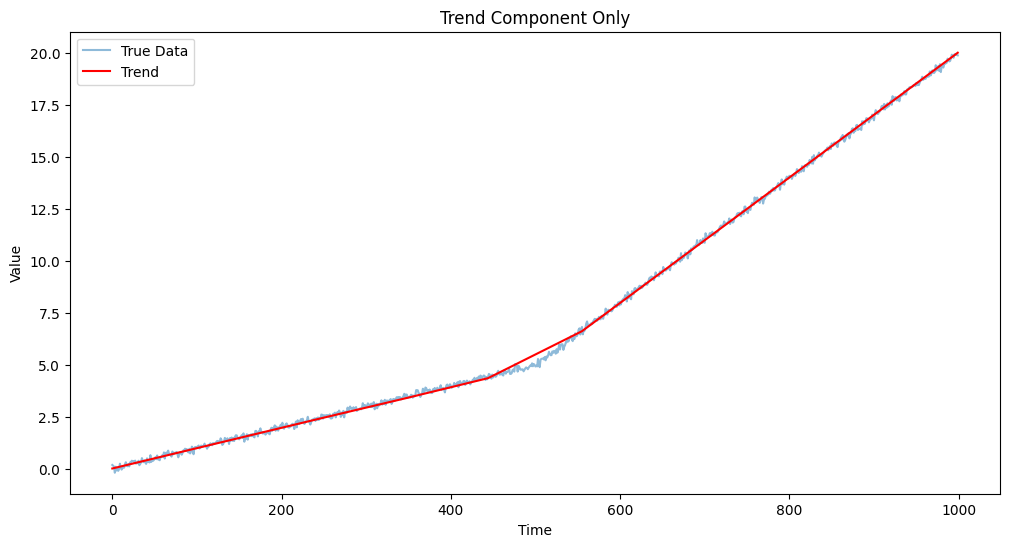

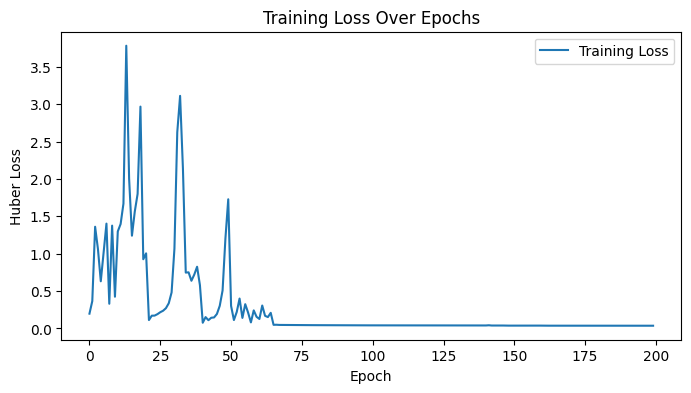

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Set random seed for reproducibility
torch.manual_seed(42)

# Trend Model


class TrendModel(nn.Module):
    def __init__(self, n_changepoints=10, trend_reg=1.0):
        super(TrendModel, self).__init__()
        self.n_changepoints = n_changepoints
        self.trend_k = nn.Parameter(torch.zeros(1))  # Initial growth rate
        self.trend_m = nn.Parameter(torch.zeros(1))  # Initial offset
        self.delta = nn.Parameter(torch.zeros(n_changepoints))  # Changepoint adjustments
        self.trend_reg = trend_reg

    def forward(self, t, changepoints):
        t = t.view(-1, 1)
        changepoints = changepoints.view(1, -1)
        A = (t >= changepoints).float()
        growth = self.trend_k + torch.sum(self.delta * A, dim=1, keepdim=True)
        offset = self.trend_m - torch.sum(self.delta * changepoints * A, dim=1, keepdim=True)
        return growth * t + offset


# Huber Loss with Regularization


def huber_loss_with_regularization(y_pred, y_true, model, beta=1.0):
    residual = y_pred - y_true
    abs_residual = torch.abs(residual)
    is_small_error = (abs_residual <= beta).float()
    small_error_loss = 0.5 * residual**2
    large_error_loss = beta * abs_residual - 0.5 * beta**2
    huber = torch.mean(is_small_error * small_error_loss + (1 - is_small_error) * large_error_loss)
    trend_reg = model.trend_reg * torch.sum(torch.abs(model.delta))
    return huber + trend_reg


# Synthetic Data


def generate_synthetic_data(n=1000):
    t = torch.linspace(0, n - 1, n)
    trend = 0.01 * t  # Base trend
    trend += (t >= 500).float() * 0.02 * (t - 500)  # Slope change at t=500
    noise = torch.normal(0, 0.1, size=(n,))
    y = trend + noise
    return t, y


# Training Function


def train_model(model, t, y, changepoints, n_epochs=200, batch_size=32, lr=0.001):
    optimizer = AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=10, verbose=True)
    losses = []

    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0.0
        for i in range(0, len(y) - batch_size, batch_size):
            idx = slice(i, i + batch_size)
            t_batch = t[idx]
            y_true_batch = y[idx].view(-1, 1)

            optimizer.zero_grad()
            y_pred = model(t_batch, changepoints)
            loss = huber_loss_with_regularization(y_pred, y_true_batch, model)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_size

        avg_loss = epoch_loss / (len(y) - batch_size)
        losses.append(avg_loss)
        scheduler.step(avg_loss)

        if epoch % 20 == 0:
            print(
                f"Epoch {epoch}, Loss: {avg_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}"
            )

    return losses


# Main Execution
if __name__ == "__main__":
    # Generate data
    t, y = generate_synthetic_data(n=1000)
    changepoints = torch.linspace(0, len(t) - 1, 10)

    # Initialize model
    model = TrendModel(n_changepoints=10, trend_reg=1.0)

    # Train
    losses = train_model(model, t, y, changepoints)

    # Predict
    model.eval()
    with torch.no_grad():
        y_pred = model(t, changepoints)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(t.numpy(), y.numpy(), label="True Data", alpha=0.5)
    plt.plot(t.numpy(), y_pred.numpy(), label="Trend", color="red")
    plt.legend()
    plt.title("Trend Component Only")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.savefig("trend_only.png")
    plt.show()

    # Plot loss
    plt.figure(figsize=(8, 4))
    plt.plot(losses, label="Training Loss")
    plt.legend()
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Huber Loss")
    plt.show()

Epoch 0, Loss: 0.8525, LR: 0.001000
Epoch 20, Loss: 0.4987, LR: 0.001000
Epoch 40, Loss: 0.2402, LR: 0.001000
Epoch 60, Loss: 0.0923, LR: 0.001000
Epoch 80, Loss: 0.0307, LR: 0.001000
Epoch 100, Loss: 0.0103, LR: 0.001000
Epoch 120, Loss: 0.0057, LR: 0.001000
Epoch 140, Loss: 0.0051, LR: 0.001000
Epoch 160, Loss: 0.0051, LR: 0.001000
Epoch 180, Loss: 0.0051, LR: 0.000250


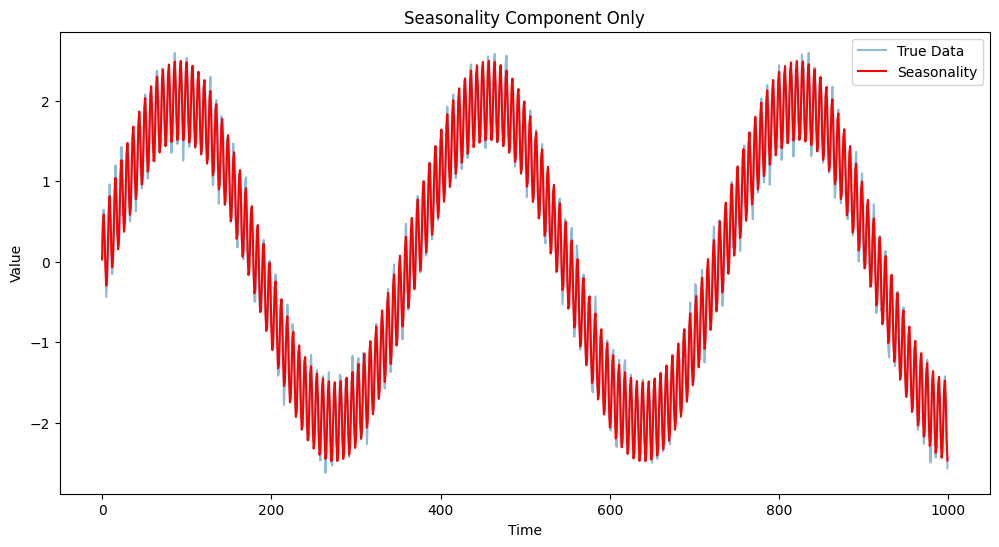

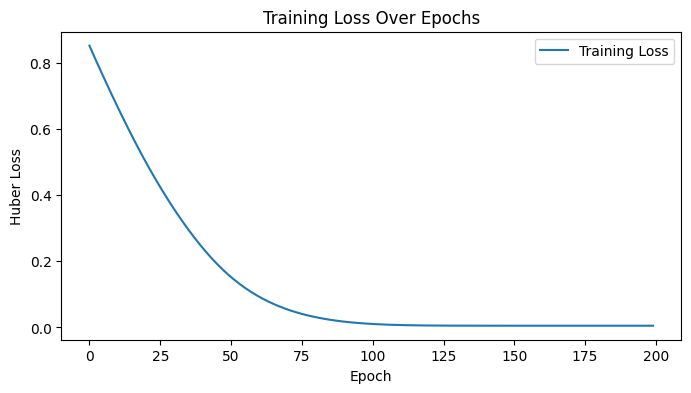

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Set random seed for reproducibility
torch.manual_seed(42)

# Seasonality Model


class SeasonalityModel(nn.Module):
    def __init__(self, yearly_seasonality=True, weekly_seasonality=True):
        super(SeasonalityModel, self).__init__()
        self.yearly_seasonality = yearly_seasonality
        self.weekly_seasonality = weekly_seasonality
        if yearly_seasonality:
            self.yearly_fourier = nn.Parameter(torch.zeros(6, 2))
        if weekly_seasonality:
            self.weekly_fourier = nn.Parameter(torch.zeros(3, 2))

    def forward(self, t):
        s = torch.zeros_like(t)
        if self.yearly_seasonality:
            for k in range(6):
                s += self.yearly_fourier[k, 0] * torch.cos(
                    2 * np.pi * (k + 1) * t / 365.25
                ) + self.yearly_fourier[k, 1] * torch.sin(2 * np.pi * (k + 1) * t / 365.25)
        if self.weekly_seasonality:
            for k in range(3):
                s += self.weekly_fourier[k, 0] * torch.cos(
                    2 * np.pi * (k + 1) * t / 7
                ) + self.weekly_fourier[k, 1] * torch.sin(2 * np.pi * (k + 1) * t / 7)
        return s.view(-1, 1)


# Huber Loss


def huber_loss(y_pred, y_true, beta=1.0):
    residual = y_pred - y_true
    abs_residual = torch.abs(residual)
    is_small_error = (abs_residual <= beta).float()
    small_error_loss = 0.5 * residual**2
    large_error_loss = beta * abs_residual - 0.5 * beta**2
    return torch.mean(is_small_error * small_error_loss + (1 - is_small_error) * large_error_loss)


# Synthetic Data


def generate_synthetic_data(n=1000):
    t = torch.linspace(0, n - 1, n)
    seasonality = 2 * torch.sin(2 * np.pi * t / 365.25) + 0.5 * torch.sin(2 * np.pi * t / 7)
    noise = torch.normal(0, 0.1, size=(n,))
    y = seasonality + noise
    return t, y


# Training Function


def train_model(model, t, y, n_epochs=200, batch_size=32, lr=0.001):
    optimizer = AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=10, verbose=True)
    losses = []

    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0.0
        for i in range(0, len(y) - batch_size, batch_size):
            idx = slice(i, i + batch_size)
            t_batch = t[idx]
            y_true_batch = y[idx].view(-1, 1)

            optimizer.zero_grad()
            y_pred = model(t_batch)
            loss = huber_loss(y_pred, y_true_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_size

        avg_loss = epoch_loss / (len(y) - batch_size)
        losses.append(avg_loss)
        scheduler.step(avg_loss)

        if epoch % 20 == 0:
            print(
                f"Epoch {epoch}, Loss: {avg_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}"
            )

    return losses


# Main Execution
if __name__ == "__main__":
    # Generate data
    t, y = generate_synthetic_data(n=1000)

    # Initialize model
    model = SeasonalityModel(yearly_seasonality=True, weekly_seasonality=True)

    # Train
    losses = train_model(model, t, y)

    # Predict
    model.eval()
    with torch.no_grad():
        y_pred = model(t)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(t.numpy(), y.numpy(), label="True Data", alpha=0.5)
    plt.plot(t.numpy(), y_pred.numpy(), label="Seasonality", color="red")
    plt.legend()
    plt.title("Seasonality Component Only")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.savefig("seasonality_only.png")
    plt.show()

    # Plot loss
    plt.figure(figsize=(8, 4))
    plt.plot(losses, label="Training Loss")
    plt.legend()
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Huber Loss")
    plt.show()

Epoch 0, Loss: 0.0312, LR: 0.001000
Epoch 20, Loss: 0.0290, LR: 0.001000
Epoch 40, Loss: 0.0267, LR: 0.001000
Epoch 60, Loss: 0.0244, LR: 0.001000
Epoch 80, Loss: 0.0221, LR: 0.001000
Epoch 100, Loss: 0.0200, LR: 0.001000
Epoch 120, Loss: 0.0179, LR: 0.001000
Epoch 140, Loss: 0.0159, LR: 0.001000
Epoch 160, Loss: 0.0141, LR: 0.001000
Epoch 180, Loss: 0.0124, LR: 0.001000


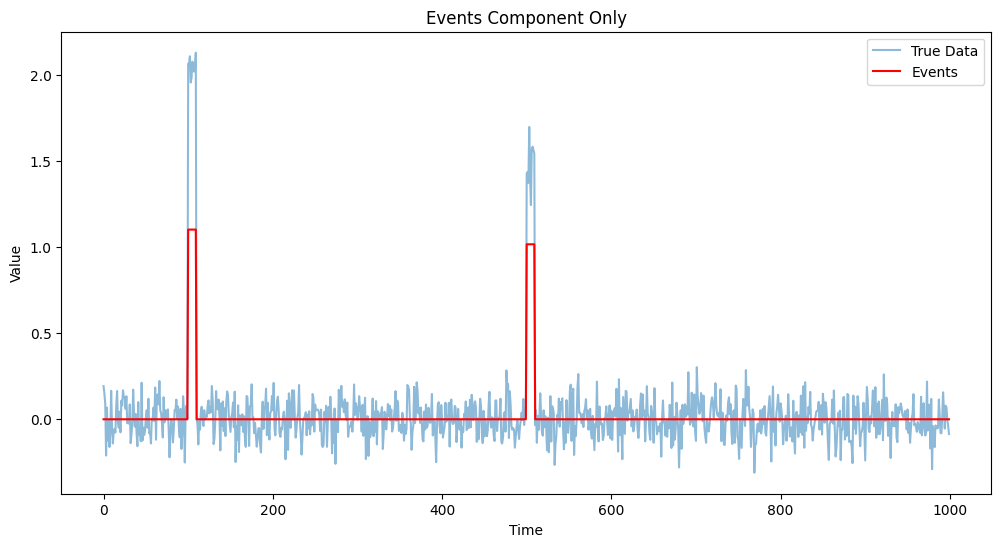

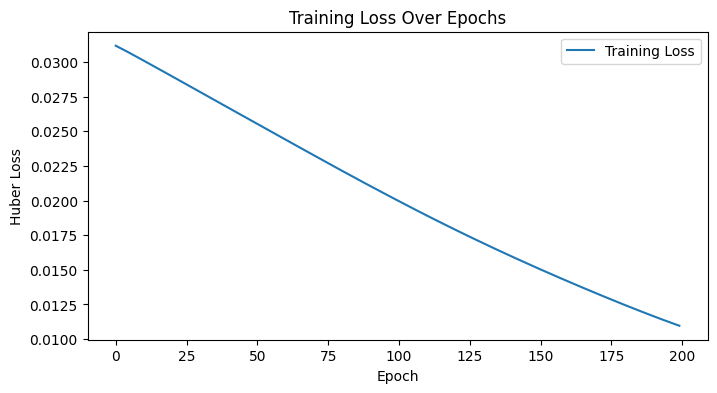

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Set random seed for reproducibility
torch.manual_seed(42)

# Events Model


class EventsModel(nn.Module):
    def __init__(self, n_events=2):
        super(EventsModel, self).__init__()
        self.n_events = n_events
        self.event_effects = nn.Parameter(torch.zeros(n_events))

    def forward(self, event_indicators):
        if self.n_events == 0:
            return torch.zeros_like(event_indicators[:, 0:1])
        return torch.sum(self.event_effects * event_indicators, dim=1, keepdim=True)


# Huber Loss


def huber_loss(y_pred, y_true, beta=1.0):
    residual = y_pred - y_true
    abs_residual = torch.abs(residual)
    is_small_error = (abs_residual <= beta).float()
    small_error_loss = 0.5 * residual**2
    large_error_loss = beta * abs_residual - 0.5 * beta**2
    return torch.mean(is_small_error * small_error_loss + (1 - is_small_error) * large_error_loss)


# Synthetic Data


def generate_synthetic_data(n=1000, n_events=2):
    t = torch.linspace(0, n - 1, n)
    y = torch.zeros(n)
    event_indicators = torch.zeros(n, n_events)
    event_indicators[100:110, 0] = 1.0  # Event 1
    event_indicators[500:510, 1] = 1.0  # Event 2
    y[100:110] += 2.0  # Effect of event 1
    y[500:510] += 1.5  # Effect of event 2
    noise = torch.normal(0, 0.1, size=(n,))
    y += noise
    return t, y, event_indicators


# Training Function


def train_model(model, t, y, event_indicators, n_epochs=200, batch_size=32, lr=0.001):
    optimizer = AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=10, verbose=True)
    losses = []

    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0.0
        for i in range(0, len(y) - batch_size, batch_size):
            idx = slice(i, i + batch_size)
            event_batch = event_indicators[idx]
            y_true_batch = y[idx].view(-1, 1)

            optimizer.zero_grad()
            y_pred = model(event_batch)
            loss = huber_loss(y_pred, y_true_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_size

        avg_loss = epoch_loss / (len(y) - batch_size)
        losses.append(avg_loss)
        scheduler.step(avg_loss)

        if epoch % 20 == 0:
            print(
                f"Epoch {epoch}, Loss: {avg_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}"
            )

    return losses


# Main Execution
if __name__ == "__main__":
    # Generate data
    t, y, event_indicators = generate_synthetic_data(n=1000, n_events=2)

    # Initialize model
    model = EventsModel(n_events=2)

    # Train
    losses = train_model(model, t, y, event_indicators)

    # Predict
    model.eval()
    with torch.no_grad():
        y_pred = model(event_indicators)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(t.numpy(), y.numpy(), label="True Data", alpha=0.5)
    plt.plot(t.numpy(), y_pred.numpy(), label="Events", color="red")
    plt.legend()
    plt.title("Events Component Only")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.savefig("events_only.png")
    plt.show()

    # Plot loss
    plt.figure(figsize=(8, 4))
    plt.plot(losses, label="Training Loss")
    plt.legend()
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Huber Loss")
    plt.show()

Epoch 0, Loss: 0.9245, LR: 0.001000
Epoch 20, Loss: 0.2421, LR: 0.001000
Epoch 40, Loss: 0.1768, LR: 0.000500
Epoch 60, Loss: 0.1767, LR: 0.000500
Epoch 80, Loss: 0.1766, LR: 0.000125
Epoch 100, Loss: 0.1766, LR: 0.000031
Epoch 120, Loss: 0.1766, LR: 0.000016
Epoch 140, Loss: 0.1766, LR: 0.000004
Epoch 160, Loss: 0.1766, LR: 0.000001
Epoch 180, Loss: 0.1766, LR: 0.000000


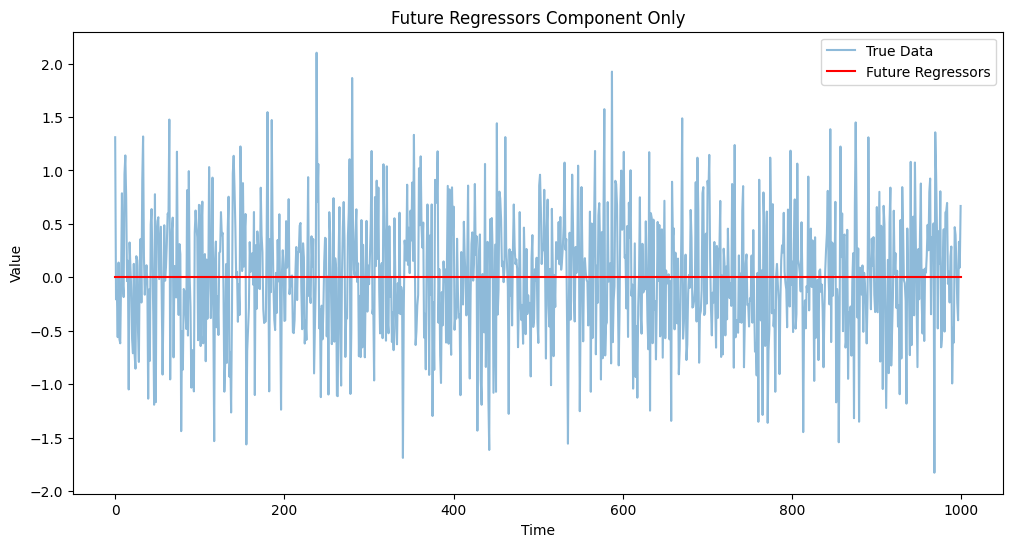

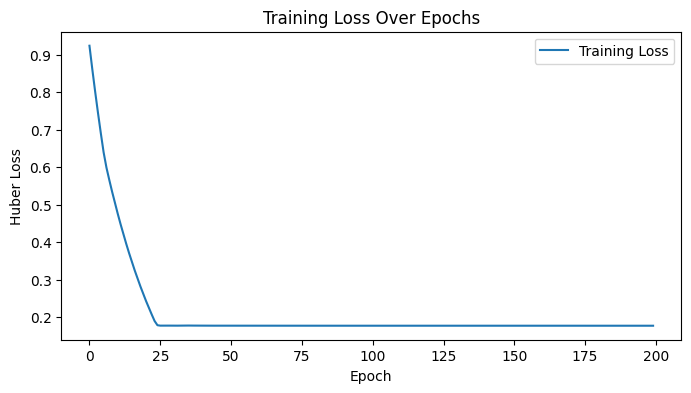

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Set random seed for reproducibility
torch.manual_seed(42)

# Future Regressors Model


class FutureRegressorsModel(nn.Module):
    def __init__(self, n_regressors=2, regressor_reg=1.0):
        super(FutureRegressorsModel, self).__init__()
        self.n_regressors = n_regressors
        self.future_regressor_net = nn.Linear(n_regressors, 1, bias=False)
        self.regressor_reg = regressor_reg

    def forward(self, regressors):
        if self.n_regressors == 0:
            return torch.zeros_like(regressors[:, 0:1])
        return self.future_regressor_net(regressors)


# Huber Loss with Regularization


def huber_loss_with_regularization(y_pred, y_true, model, beta=1.0):
    residual = y_pred - y_true
    abs_residual = torch.abs(residual)
    is_small_error = (abs_residual <= beta).float()
    small_error_loss = 0.5 * residual**2
    large_error_loss = beta * abs_residual - 0.5 * beta**2
    huber = torch.mean(is_small_error * small_error_loss + (1 - is_small_error) * large_error_loss)
    regressor_reg = model.regressor_reg * torch.sum(torch.abs(model.future_regressor_net.weight))
    return huber + regressor_reg


# Synthetic Data


def generate_synthetic_data(n=1000, n_regressors=2):
    t = torch.linspace(0, n - 1, n)
    regressors = torch.randn(n, n_regressors)
    y = 0.5 * regressors[:, 0] + 0.3 * regressors[:, 1]  # Linear combination
    noise = torch.normal(0, 0.1, size=(n,))
    y += noise
    return t, y, regressors


# Training Function


def train_model(model, t, y, regressors, n_epochs=200, batch_size=32, lr=0.001):
    optimizer = AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=10, verbose=True)
    losses = []

    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0.0
        for i in range(0, len(y) - batch_size, batch_size):
            idx = slice(i, i + batch_size)
            regressor_batch = regressors[idx]
            y_true_batch = y[idx].view(-1, 1)

            optimizer.zero_grad()
            y_pred = model(regressor_batch)
            loss = huber_loss_with_regularization(y_pred, y_true_batch, model)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_size

        avg_loss = epoch_loss / (len(y) - batch_size)
        losses.append(avg_loss)
        scheduler.step(avg_loss)

        if epoch % 20 == 0:
            print(
                f"Epoch {epoch}, Loss: {avg_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}"
            )

    return losses


# Main Execution
if __name__ == "__main__":
    # Generate data
    t, y, regressors = generate_synthetic_data(n=1000, n_regressors=2)

    # Initialize model
    model = FutureRegressorsModel(n_regressors=2, regressor_reg=1.0)

    # Train
    losses = train_model(model, t, y, regressors)

    # Predict
    model.eval()
    with torch.no_grad():
        y_pred = model(regressors)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(t.numpy(), y.numpy(), label="True Data", alpha=0.5)
    plt.plot(t.numpy(), y_pred.numpy(), label="Future Regressors", color="red")
    plt.legend()
    plt.title("Future Regressors Component Only")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.savefig("future_regressors_only.png")
    plt.show()

    # Plot loss
    plt.figure(figsize=(8, 4))
    plt.plot(losses, label="Training Loss")
    plt.legend()
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Huber Loss")
    plt.show()

Epoch 0, Loss: 0.0107, LR: 0.001000
Epoch 20, Loss: 0.0050, LR: 0.001000
Epoch 40, Loss: 0.0050, LR: 0.001000
Epoch 60, Loss: 0.0050, LR: 0.001000
Epoch 80, Loss: 0.0050, LR: 0.001000
Epoch 100, Loss: 0.0050, LR: 0.001000
Epoch 120, Loss: 0.0163, LR: 0.000250
Epoch 140, Loss: 0.0095, LR: 0.000125
Epoch 160, Loss: 0.0064, LR: 0.000031
Epoch 180, Loss: 0.0055, LR: 0.000008


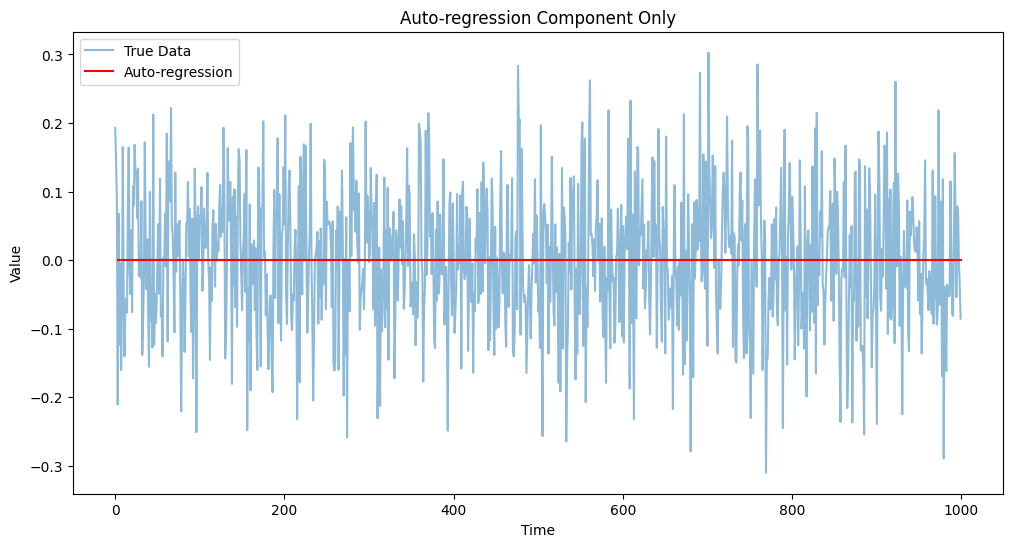

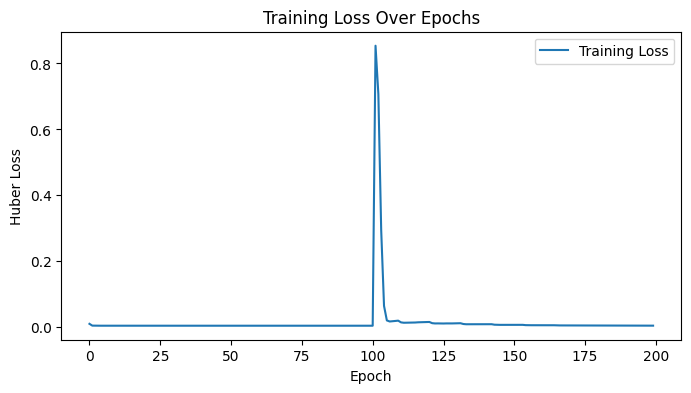

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Set random seed for reproducibility
torch.manual_seed(42)

# Auto-regression Model


class AutoRegressionModel(nn.Module):
    def __init__(self, n_lags=3, ar_hidden_size=32, ar_sparsity=3.0):
        super(AutoRegressionModel, self).__init__()
        self.n_lags = n_lags
        self.ar_net = nn.Sequential(
            nn.Linear(n_lags, ar_hidden_size), nn.ReLU(), nn.Linear(ar_hidden_size, 1)
        )
        self.ar_sparsity = ar_sparsity

    def forward(self, y_lagged):
        return self.ar_net(y_lagged)


# Huber Loss with Regularization


def huber_loss_with_regularization(y_pred, y_true, model, beta=1.0, epoch=0, total_epochs=200):
    residual = y_pred - y_true
    abs_residual = torch.abs(residual)
    is_small_error = (abs_residual <= beta).float()
    small_error_loss = 0.5 * residual**2
    large_error_loss = beta * abs_residual - 0.5 * beta**2
    huber = torch.mean(is_small_error * small_error_loss + (1 - is_small_error) * large_error_loss)
    reg_lambda = min(1.0, max(0.0, (epoch - 0.5 * total_epochs) / (0.5 * total_epochs)))
    ar_reg = 0.0
    if model.ar_sparsity > 0:
        for param in model.ar_net.parameters():
            ar_reg += model.ar_sparsity * torch.sum(torch.log(1 + torch.abs(param)))
    return huber + reg_lambda * ar_reg


# Synthetic Data


def generate_synthetic_data(n=1000, n_lags=3):
    t = torch.linspace(0, n - 1, n)
    y = torch.zeros(n)
    for i in range(n_lags, n):
        y[i] = 0.5 * y[i - 1] + 0.3 * y[i - 2] - 0.1 * y[i - 3]
    noise = torch.normal(0, 0.1, size=(n,))
    y += noise
    return t, y


# Training Function


def train_model(model, t, y, n_lags, n_epochs=200, batch_size=32, lr=0.001):
    optimizer = AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=10, verbose=True)
    dataset_size = len(y) - n_lags
    losses = []

    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0.0
        for i in range(0, dataset_size, batch_size):
            batch_end = min(i + batch_size, dataset_size)
            idx = slice(i + n_lags, batch_end + n_lags)
            y_lagged_batch = torch.stack(
                [y[i + j : i + j + n_lags] for j in range(batch_end - i)], dim=0
            )
            y_true_batch = y[idx].view(-1, 1)

            optimizer.zero_grad()
            y_pred = model(y_lagged_batch)
            loss = huber_loss_with_regularization(
                y_pred, y_true_batch, model, epoch=epoch, total_epochs=n_epochs
            )
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * (batch_end - i)

        avg_loss = epoch_loss / dataset_size
        losses.append(avg_loss)
        scheduler.step(avg_loss)

        if epoch % 20 == 0:
            print(
                f"Epoch {epoch}, Loss: {avg_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}"
            )

    return losses


# Main Execution
if __name__ == "__main__":
    # Generate data
    t, y = generate_synthetic_data(n=1000, n_lags=3)

    # Initialize model
    model = AutoRegressionModel(n_lags=3, ar_sparsity=3.0)

    # Train
    losses = train_model(model, t, y, n_lags=3)

    # Predict
    model.eval()
    with torch.no_grad():
        y_lagged = torch.stack([y[i : i + 3] for i in range(len(y) - 3)], dim=0)
        y_pred = model(y_lagged)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(t.numpy(), y.numpy(), label="True Data", alpha=0.5)
    plt.plot(t[3:].numpy(), y_pred.numpy(), label="Auto-regression", color="red")
    plt.legend()
    plt.title("Auto-regression Component Only")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.savefig("autoregression_only.png")
    plt.show()

    # Plot loss
    plt.figure(figsize=(8, 4))
    plt.plot(losses, label="Training Loss")
    plt.legend()
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Huber Loss")
    plt.show()

Epoch 0, Loss: 1.5987, LR: 0.001000
Epoch 20, Loss: 0.1542, LR: 0.001000
Epoch 40, Loss: 0.1536, LR: 0.000500
Epoch 60, Loss: 0.1535, LR: 0.000250
Epoch 80, Loss: 0.1533, LR: 0.000063
Epoch 100, Loss: 0.1533, LR: 0.000031
Epoch 120, Loss: 0.1533, LR: 0.000008
Epoch 140, Loss: 0.1533, LR: 0.000002
Epoch 160, Loss: 0.1533, LR: 0.000001
Epoch 180, Loss: 0.1533, LR: 0.000000


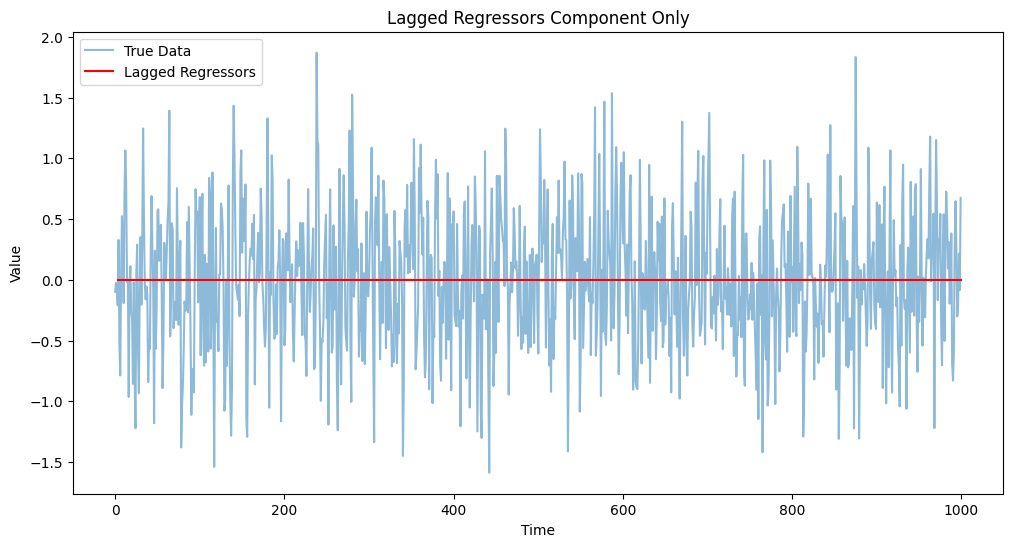

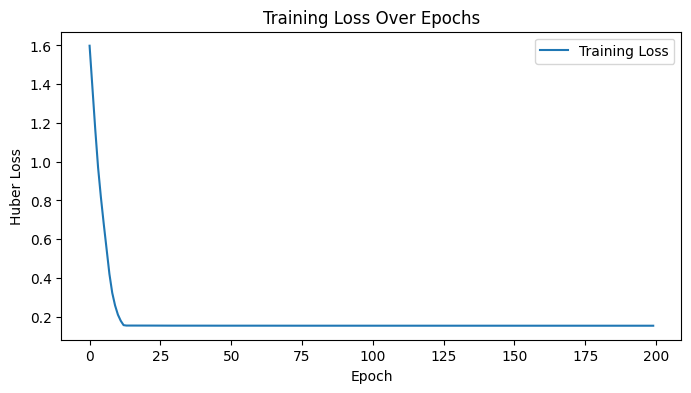

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Set random seed for reproducibility
torch.manual_seed(42)

# Lagged Regressors Model


class LaggedRegressorsModel(nn.Module):
    def __init__(self, n_regressors=2, n_lags=3, regressor_reg=1.0):
        super(LaggedRegressorsModel, self).__init__()
        self.n_regressors = n_regressors
        self.n_lags = n_lags
        self.lagged_regressor_net = nn.Linear(n_regressors * n_lags, 1, bias=False)
        self.regressor_reg = regressor_reg

    def forward(self, lagged_regressors):
        if self.n_regressors == 0:
            return torch.zeros_like(lagged_regressors[:, 0:1])
        return self.lagged_regressor_net(lagged_regressors.view(lagged_regressors.size(0), -1))


# Huber Loss with Regularization


def huber_loss_with_regularization(y_pred, y_true, model, beta=1.0):
    residual = y_pred - y_true
    abs_residual = torch.abs(residual)
    is_small_error = (abs_residual <= beta).float()
    small_error_loss = 0.5 * residual**2
    large_error_loss = beta * abs_residual - 0.5 * beta**2
    huber = torch.mean(is_small_error * small_error_loss + (1 - is_small_error) * large_error_loss)
    regressor_reg = model.regressor_reg * torch.sum(torch.abs(model.lagged_regressor_net.weight))
    return huber + regressor_reg


# Synthetic Data


def generate_synthetic_data(n=1000, n_regressors=2, n_lags=3):
    t = torch.linspace(0, n - 1, n)
    regressors = torch.randn(n, n_regressors)
    lagged_regressors = torch.zeros(n, n_regressors, n_lags)
    for lag in range(n_lags):
        lagged_regressors[lag:, :, lag] = regressors[: n - lag, :]

    y = torch.zeros(n)
    for i in range(n_lags, n):
        y[i] = (
            0.4 * lagged_regressors[i, 0, 0]
            + 0.2 * lagged_regressors[i, 0, 1]
            + 0.3 * lagged_regressors[i, 1, 0]
            - 0.1 * lagged_regressors[i, 1, 2]
        )
    noise = torch.normal(0, 0.1, size=(n,))
    y += noise
    return t, y, lagged_regressors


# Training Function


def train_model(model, t, y, lagged_regressors, n_lags, n_epochs=200, batch_size=32, lr=0.001):
    optimizer = AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=10, verbose=True)
    dataset_size = len(y) - n_lags
    losses = []

    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0.0
        for i in range(0, dataset_size, batch_size):
            batch_end = min(i + batch_size, dataset_size)
            idx = slice(i + n_lags, batch_end + n_lags)
            lagged_reg_batch = lagged_regressors[i:batch_end]
            y_true_batch = y[idx].view(-1, 1)

            optimizer.zero_grad()
            y_pred = model(lagged_reg_batch)
            loss = huber_loss_with_regularization(y_pred, y_true_batch, model)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * (batch_end - i)

        avg_loss = epoch_loss / dataset_size
        losses.append(avg_loss)
        scheduler.step(avg_loss)

        if epoch % 20 == 0:
            print(
                f"Epoch {epoch}, Loss: {avg_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}"
            )

    return losses


# Main Execution
if __name__ == "__main__":
    # Generate data
    t, y, lagged_regressors = generate_synthetic_data(n=1000, n_regressors=2, n_lags=3)

    # Initialize model
    model = LaggedRegressorsModel(n_regressors=2, n_lags=3, regressor_reg=1.0)

    # Train
    losses = train_model(model, t, y, lagged_regressors, n_lags=3)

    # Predict
    model.eval()
    with torch.no_grad():
        y_pred = model(lagged_regressors[:-3])

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(t.numpy(), y.numpy(), label="True Data", alpha=0.5)
    plt.plot(t[3:].numpy(), y_pred.numpy(), label="Lagged Regressors", color="red")
    plt.legend()
    plt.title("Lagged Regressors Component Only")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.savefig("lagged_regressors_only.png")
    plt.show()

    # Plot loss
    plt.figure(figsize=(8, 4))
    plt.plot(losses, label="Training Loss")
    plt.legend()
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Huber Loss")
    plt.show()

Epoch 0, Loss: 2.1675, LR: 0.001000
Epoch 20, Loss: 1.4270, LR: 0.001000
Epoch 40, Loss: 0.3958, LR: 0.000500
Epoch 60, Loss: 0.2773, LR: 0.000250
Epoch 80, Loss: 0.8736, LR: 0.000250
Epoch 100, Loss: 0.0638, LR: 0.000063
Epoch 120, Loss: 16.3737, LR: 0.000031
Epoch 140, Loss: 30.5344, LR: 0.000008
Epoch 160, Loss: 44.8904, LR: 0.000002
Epoch 180, Loss: 59.5186, LR: 0.000000


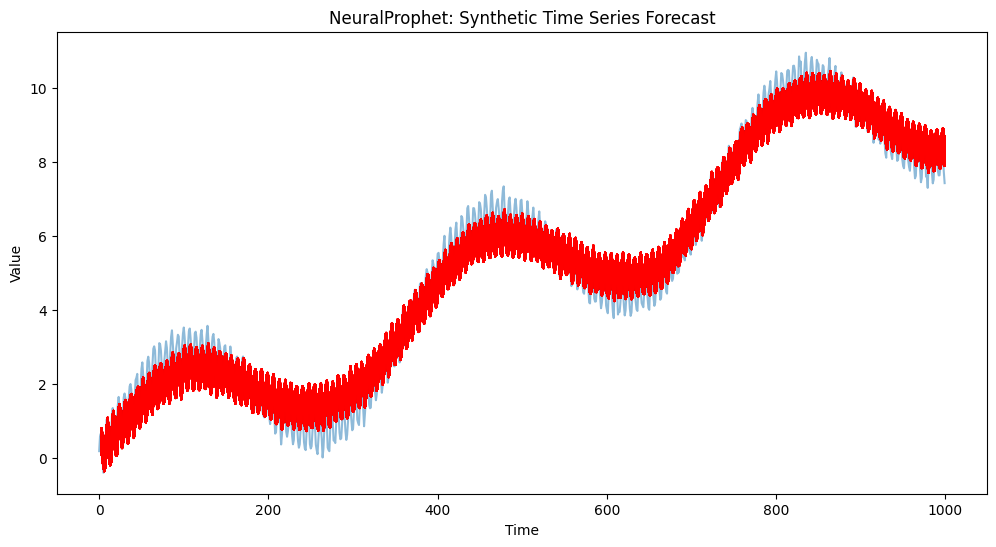

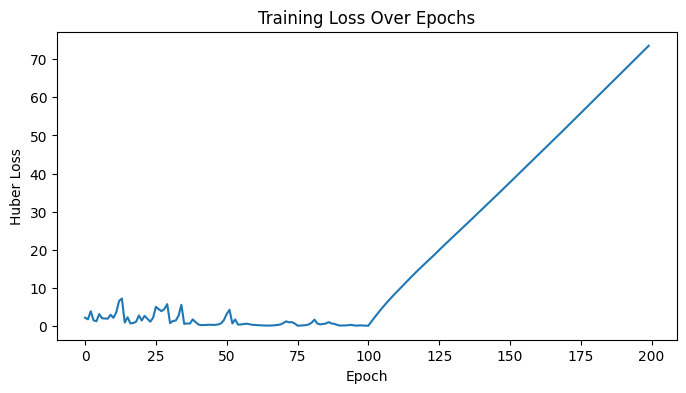

In [97]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Set random seed for reproducibility
torch.manual_seed(42)

# 1. NeuralProphet Model Definition


class NeuralProphet(nn.Module):
    def __init__(
        self,
        n_lags=3,
        n_forecasts=1,
        n_changepoints=10,
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=True,
        n_events=0,
        n_regressors=0,
        ar_hidden_size=32,
        seasonality_mode="additive",
        ar_sparsity=3.0,
        trend_reg=1.0,
        regressor_reg=1.0,
    ):
        super(NeuralProphet, self).__init__()

        # Model parameters
        self.n_lags = n_lags
        self.n_forecasts = n_forecasts
        self.n_changepoints = n_changepoints
        self.n_events = n_events
        self.n_regressors = n_regressors
        self.seasonality_mode = seasonality_mode

        # Trend: Piecewise linear with changepoints
        self.trend_k = nn.Parameter(torch.zeros(1))  # Initial growth rate
        self.trend_m = nn.Parameter(torch.zeros(1))  # Initial offset
        self.delta = nn.Parameter(torch.zeros(n_changepoints))  # Changepoint adjustments

        # Seasonality: Fourier series components
        self.yearly_seasonality = yearly_seasonality
        self.weekly_seasonality = weekly_seasonality
        self.daily_seasonality = daily_seasonality

        if yearly_seasonality:
            self.yearly_fourier = nn.Parameter(torch.zeros(6, 2))  # k=6 for yearly
        if weekly_seasonality:
            self.weekly_fourier = nn.Parameter(torch.zeros(3, 2))  # k=3 for weekly
        if daily_seasonality:
            self.daily_fourier = nn.Parameter(torch.zeros(6, 2))  # k=6 for daily

        # Auto-regression: Deep AR-Net with ReLU
        self.ar_net = nn.Sequential(
            nn.Linear(n_lags, ar_hidden_size), nn.ReLU(), nn.Linear(ar_hidden_size, n_forecasts)
        )
        self.ar_sparsity = ar_sparsity  # Sparsity parameter for AR regularization

        # Events: Binary indicators with learnable effects
        if n_events > 0:
            self.event_effects = nn.Parameter(torch.zeros(n_events))

        # Future and Lagged Regressors
        if n_regressors > 0:
            self.future_regressor_net = nn.Linear(n_regressors, n_forecasts, bias=False)
            self.lagged_regressor_net = nn.Linear(n_regressors * n_lags, n_forecasts, bias=False)

        # Regularization parameters
        self.trend_reg = trend_reg
        self.regressor_reg = regressor_reg

    def trend(self, t, changepoints):
        """Piecewise linear trend with changepoints"""
        t = t.view(-1, 1)
        changepoints = changepoints.view(1, -1)
        A = (t >= changepoints).float()  # Binary indicator for changepoints
        growth = self.trend_k + torch.sum(self.delta * A, dim=1, keepdim=True)
        offset = self.trend_m - torch.sum(self.delta * changepoints * A, dim=1, keepdim=True)
        return growth * t + offset

    def seasonality(self, t):
        """Fourier series for seasonality"""
        s = torch.zeros_like(t)

        if self.yearly_seasonality:
            for k in range(6):
                s += self.yearly_fourier[k, 0] * torch.cos(
                    2 * np.pi * (k + 1) * t / 365.25
                ) + self.yearly_fourier[k, 1] * torch.sin(2 * np.pi * (k + 1) * t / 365.25)

        if self.weekly_seasonality:
            for k in range(3):
                s += self.weekly_fourier[k, 0] * torch.cos(
                    2 * np.pi * (k + 1) * t / 7
                ) + self.weekly_fourier[k, 1] * torch.sin(2 * np.pi * (k + 1) * t / 7)

        if self.daily_seasonality:
            for k in range(6):
                s += self.daily_fourier[k, 0] * torch.cos(
                    2 * np.pi * (k + 1) * t / 1
                ) + self.daily_fourier[k, 1] * torch.sin(2 * np.pi * (k + 1) * t / 1)

        return s

    def autoregression(self, y_lagged):
        """Auto-regression using deep AR-Net"""
        return self.ar_net(y_lagged)

    def events(self, event_indicators):
        """Event effects"""
        if self.n_events == 0:
            return torch.zeros_like(event_indicators[:, 0:1])
        return torch.sum(self.event_effects * event_indicators, dim=1, keepdim=True)

    def future_regressors(self, regressors):
        """Future regressors"""
        if self.n_regressors == 0:
            return torch.zeros_like(regressors[:, 0:1])
        return self.future_regressor_net(regressors)

    def lagged_regressors(self, lagged_regressors):
        """Lagged regressors"""
        if self.n_regressors == 0:
            return torch.zeros_like(lagged_regressors[:, 0:1])
        return self.lagged_regressor_net(lagged_regressors.view(lagged_regressors.size(0), -1))

    def forward(
        self,
        t,
        y_lagged,
        changepoints,
        event_indicators=None,
        future_regressors=None,
        lagged_regressors=None,
    ):
        """Forward pass combining all components"""
        T = self.trend(t, changepoints)  # Trend
        S = self.seasonality(t)  # Seasonality
        A = self.autoregression(y_lagged)  # Auto-regression
        E = self.events(event_indicators)  # Events
        F = self.future_regressors(future_regressors)  # Future regressors
        L = self.lagged_regressors(lagged_regressors)  # Lagged regressors

        if self.seasonality_mode == "additive":
            return T + S + A + E + F + L
        else:  # Multiplicative
            return T * (1 + S + E + F) + A + L


# 2. Huber Loss with Regularization


def huber_loss_with_regularization(y_pred, y_true, model, beta=1.0, epoch=0, total_epochs=200):
    """Huber loss with trend, AR, and regressor regularization"""
    residual = y_pred - y_true
    abs_residual = torch.abs(residual)
    is_small_error = (abs_residual <= beta).float()
    small_error_loss = 0.5 * residual**2
    large_error_loss = beta * abs_residual - 0.5 * beta**2
    huber = torch.mean(is_small_error * small_error_loss + (1 - is_small_error) * large_error_loss)

    # Regularization (scaled after 50% of training, as per paper)
    reg_lambda = min(1.0, max(0.0, (epoch - 0.5 * total_epochs) / (0.5 * total_epochs)))

    # Trend regularization (L1 on delta for sparsity)
    trend_reg = model.trend_reg * torch.sum(torch.abs(model.delta))

    # AR regularization (scaled log-transform, Equation 7)
    ar_reg = 0.0
    if model.ar_sparsity > 0:
        for param in model.ar_net.parameters():
            ar_reg += model.ar_sparsity * torch.sum(torch.log(1 + torch.abs(param)))

    # Regressor regularization
    regressor_reg = 0.0
    if model.n_regressors > 0:
        for net in [model.future_regressor_net, model.lagged_regressor_net]:
            for param in net.parameters():
                regressor_reg += model.regressor_reg * torch.sum(torch.abs(param))

    return huber + reg_lambda * (trend_reg + ar_reg + regressor_reg)


# 3. Data Preparation (Synthetic Example with Events and Regressors)


def generate_synthetic_data(n=1000, n_events=2, n_regressors=2, n_lags=3):
    t = torch.linspace(0, n - 1, n)
    trend = 0.01 * t
    seasonality = 2 * torch.sin(2 * np.pi * t / 365.25) + 0.5 * torch.sin(2 * np.pi * t / 7)
    noise = torch.normal(0, 0.1, size=(n,))
    y = trend + seasonality + noise

    # Events: Binary indicators for two events (e.g., holidays)
    event_indicators = torch.zeros(n, n_events)
    event_indicators[100:110, 0] = 1.0  # Event 1
    event_indicators[500:510, 1] = 1.0  # Event 2

    # Regressors: Synthetic external variables
    regressors = torch.randn(n, n_regressors)
    # Generate lagged regressors: [n, n_regressors, n_lags]
    lagged_regressors = torch.zeros(n, n_regressors, n_lags)
    for lag in range(n_lags):
        lagged_regressors[lag:, :, lag] = regressors[: n - lag, :]

    return t, y, event_indicators, regressors, lagged_regressors


# 4. Training Function


def train_model(
    model,
    t,
    y,
    changepoints,
    event_indicators,
    regressors,
    lagged_regressors,
    n_lags,
    n_epochs=200,
    batch_size=32,
    lr=0.001,
):
    optimizer = AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=10, verbose=True)
    dataset_size = len(y) - n_lags - model.n_forecasts + 1
    losses = []

    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0.0
        for i in range(0, dataset_size, batch_size):
            batch_end = min(i + batch_size, dataset_size)
            idx = slice(i + n_lags, batch_end + n_lags)

            t_batch = t[idx]
            y_lagged_batch = torch.stack(
                [y[i + j : i + j + n_lags] for j in range(batch_end - i)], dim=0
            )
            y_true_batch = y[idx].view(-1, 1)
            event_batch = event_indicators[idx] if model.n_events > 0 else None
            future_reg_batch = regressors[idx] if model.n_regressors > 0 else None
            lagged_reg_batch = lagged_regressors[i:batch_end] if model.n_regressors > 0 else None

            optimizer.zero_grad()
            y_pred = model(
                t_batch,
                y_lagged_batch,
                changepoints,
                event_batch,
                future_reg_batch,
                lagged_reg_batch,
            )
            loss = huber_loss_with_regularization(
                y_pred, y_true_batch, model, beta=1.0, epoch=epoch, total_epochs=n_epochs
            )
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * (batch_end - i)

        avg_loss = epoch_loss / dataset_size
        losses.append(avg_loss)
        scheduler.step(avg_loss)

        if epoch % 20 == 0:
            print(
                f"Epoch {epoch}, Loss: {avg_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}"
            )

    return losses


# 5. Main Execution
if __name__ == "__main__":
    # Generate synthetic data
    t, y, event_indicators, regressors, lagged_regressors = generate_synthetic_data(
        n=1000, n_events=2, n_regressors=2, n_lags=3
    )

    # Define changepoints
    changepoints = torch.linspace(0, len(t) - 1, 10)

    # Initialize model
    model = NeuralProphet(
        n_lags=3,
        n_forecasts=1,
        n_changepoints=10,
        n_events=2,
        n_regressors=2,
        seasonality_mode="additive",
        ar_sparsity=3.0,
        trend_reg=1.0,
        regressor_reg=1.0,
    )

    # Train the model
    losses = train_model(
        model, t, y, changepoints, event_indicators, regressors, lagged_regressors, n_lags=3
    )

    # Predict
    model.eval()
    with torch.no_grad():
        idx = slice(3, len(y))
        y_lagged = torch.stack([y[i : i + 3] for i in range(len(y) - 3)], dim=0)
        t_pred = t[idx]
        event_pred = event_indicators[idx]
        future_reg_pred = regressors[idx]
        lagged_reg_pred = lagged_regressors[: len(y) - 3]
        y_pred = model(
            t_pred, y_lagged, changepoints, event_pred, future_reg_pred, lagged_reg_pred
        )

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(t.numpy(), y.numpy(), label="True Data", alpha=0.5)
    plt.plot(t_pred.numpy(), y_pred.numpy(), label="Predicted", color="red")
    # plt.legend()
    plt.title("NeuralProphet: Synthetic Time Series Forecast")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.show()

    # Plot training loss
    plt.figure(figsize=(8, 4))
    plt.plot(losses, label="Training Loss")
    # plt.legend()
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Huber Loss")
    plt.savefig("training_loss.png")
    plt.show()

In [2]:
## Piecewise linear trend with changepoints

In [8]:
import numpy as np
import torch
import torch.nn as nn

In [11]:
# 3. Data Preparation (Synthetic Example with Events and Regressors)


def generate_synthetic_data(n=1000, n_events=2, n_regressors=2):
    t = torch.linspace(0, n - 1, n)
    trend = 0.01 * t
    seasonality = 2 * torch.sin(2 * np.pi * t / 365.25) + 0.5 * torch.sin(2 * np.pi * t / 7)
    noise = torch.normal(0, 0.1, size=(n,))
    y = trend + seasonality + noise

    # Events: Binary indicators for two events (e.g., holidays)
    event_indicators = torch.zeros(n, n_events)
    event_indicators[100:110, 0] = 1.0  # Event 1
    event_indicators[500:510, 1] = 1.0  # Event 2

    # Regressors: Synthetic external variables
    future_regressors = torch.randn(n, n_regressors)
    lagged_regressors = torch.randn(n, n_regressors)

    return t, y, event_indicators, future_regressors, lagged_regressors

In [43]:
t, y, event_indicators, future_regressors, lagged_regressors = generate_synthetic_data(
    n=1000, n_events=2, n_regressors=2
)

<Axes: xlabel='None', ylabel='None'>

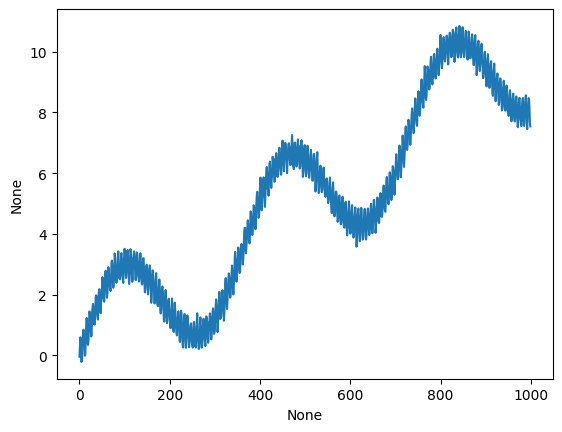

In [44]:
import seaborn as sns

sns.lineplot(x=t, y=y)

In [45]:
changepoints = torch.linspace(0, len(t) - 1, 10)

In [46]:
t = t.view(-1, 1)
changepoints = changepoints.view(1, -1)
A = (t >= changepoints).float()  # Binary indicator for changepoints
growth = trend_k + torch.sum(delta * A, dim=1, keepdim=True)
offset = trend_m - torch.sum(delta * changepoints * A, dim=1, keepdim=True)
return growth * t + offset

NameError: name 'self' is not defined

In [51]:
t = t.view(-1, 1)
changepoints = changepoints.view(1, -1)
A = (t >= changepoints).float()

In [58]:
trend_k = nn.Parameter(torch.zeros(1))  # Initial growth rate
trend_m = nn.Parameter(torch.zeros(1))  # Initial offset
delta = nn.Parameter(torch.zeros(10))  # Changepoint adjustments

In [64]:
torch.sum(delta * A, dim=1, keepdim=True).shape

torch.Size([1000, 1])

In [66]:
nn.Parameter(torch.zeros(6, 2))

Parameter containing:
tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]], requires_grad=True)

In [68]:
yearly_seasonality = nn.Parameter(torch.zeros(6, 2))

In [70]:
yearly_seasonality[1, 0]

tensor(0., grad_fn=<SelectBackward0>)

In [82]:
np.random.rand()

0.0538575550555509

<Axes: >

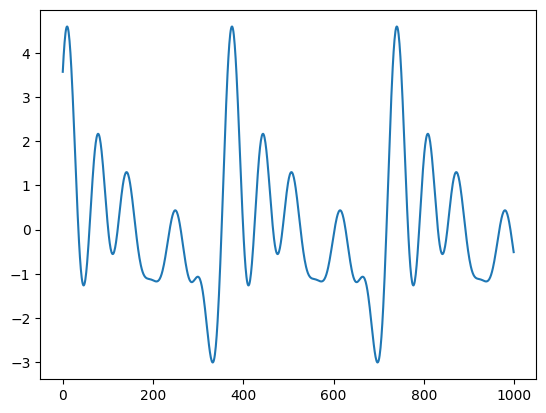

In [91]:
seasonal = 0
for i in range(6):
    seasonal += (
        np.random.rand() * torch.cos(2 * np.pi * (i + 1) * t / 365.25).flatten()
        + np.random.rand() * torch.sin(2 * np.pi * (i + 1) * t / 365.25).flatten()
    )
sns.lineplot(seasonal)

<Axes: >

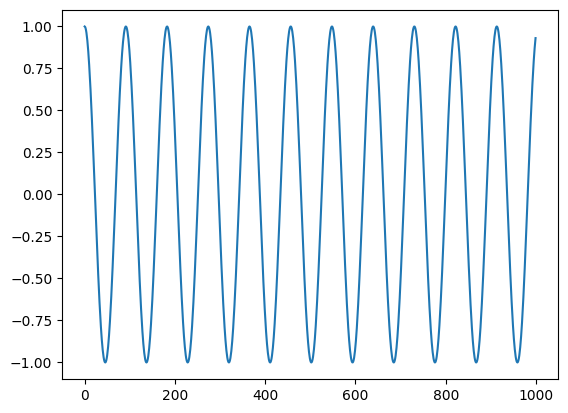

In [75]:
sns.lineplot(torch.cos(2 * np.pi * (3 + 1) * t / 365.25).flatten())